<a href="https://colab.research.google.com/github/Aravinda89/Pytorch-Tutorial/blob/main/Fixed_Feature_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning - Fixed Feature Extractor


## Creating and using a Fixed Feature Extractor


In [5]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=True, download=True,transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


Extracting /root/.pytorch/CIFAR10/cifar-10-python.tar.gz to /root/.pytorch/CIFAR10


In [9]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [11]:
for param in model.parameters():
  param.requires_grad = False

In [12]:
model.classifier[-1] = nn.Sequential(
                      nn.Linear(in_features=4096, out_features=10),
                      nn.LogSoftmax(dim=1)
                      )

In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [13]:
criterion = nn.NLLLoss()

## Training the Fixed Feature Extractor

In [14]:
device

device(type='cuda')

In [15]:
from torch.optim import Adam

model = model.to(device)
optimizer = Adam(model.parameters())

In [16]:
num_epochs = 1
batch_loss = 0
cum_epoch_loss = 0

for e in range(num_epochs):
  cum_epoch_loss = 0
  
  for batch, (images, labels) in enumerate(trainloader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})  Batch loss : {loss.item()}')
    
  print(f'Training loss : {batch_loss/len(trainloader)}')  
    

Epoch(0/1 : Batch number(1/782)  Batch loss : 2.3982882499694824
Epoch(0/1 : Batch number(2/782)  Batch loss : 2.156689405441284
Epoch(0/1 : Batch number(3/782)  Batch loss : 2.0974912643432617
Epoch(0/1 : Batch number(4/782)  Batch loss : 1.8526372909545898
Epoch(0/1 : Batch number(5/782)  Batch loss : 1.8185367584228516
Epoch(0/1 : Batch number(6/782)  Batch loss : 1.7368552684783936
Epoch(0/1 : Batch number(7/782)  Batch loss : 1.5838180780410767
Epoch(0/1 : Batch number(8/782)  Batch loss : 1.4960788488388062
Epoch(0/1 : Batch number(9/782)  Batch loss : 1.3242506980895996
Epoch(0/1 : Batch number(10/782)  Batch loss : 1.249369502067566
Epoch(0/1 : Batch number(11/782)  Batch loss : 1.30985426902771
Epoch(0/1 : Batch number(12/782)  Batch loss : 1.1479734182357788
Epoch(0/1 : Batch number(13/782)  Batch loss : 1.0021299123764038
Epoch(0/1 : Batch number(14/782)  Batch loss : 0.9140740633010864
Epoch(0/1 : Batch number(15/782)  Batch loss : 0.9682736992835999
Epoch(0/1 : Batch numbe

## Evaluating thet network and viewing images

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [18]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  print(output)


tensor([[1.0787e-03, 1.3690e-02, 8.0182e-03, 7.9596e-01, 1.4491e-04, 3.4324e-02,
         1.3441e-01, 9.5093e-03, 1.8785e-03, 9.9225e-04],
        [4.8904e-02, 5.6434e-01, 2.7638e-05, 2.5152e-05, 7.2671e-06, 5.8636e-06,
         2.1539e-05, 4.9652e-06, 3.8297e-01, 3.6944e-03],
        [7.7484e-04, 3.3058e-03, 4.0012e-07, 4.6047e-07, 4.4840e-07, 1.6164e-08,
         2.1417e-08, 5.2920e-07, 9.9588e-01, 4.1588e-05],
        [5.3985e-01, 2.1046e-03, 1.9356e-01, 6.2174e-02, 8.5054e-04, 8.8313e-04,
         2.1353e-03, 2.1995e-03, 1.9408e-01, 2.1611e-03],
        [8.4428e-08, 1.0254e-06, 4.0029e-03, 1.9224e-04, 7.0415e-05, 1.3584e-05,
         9.9572e-01, 1.1330e-07, 7.1407e-08, 4.4102e-07],
        [5.2007e-06, 1.0104e-05, 7.8435e-05, 2.9784e-02, 2.5976e-03, 5.1040e-02,
         9.1627e-01, 1.9727e-04, 3.3711e-07, 1.7974e-05],
        [9.6630e-06, 9.9195e-01, 2.8658e-07, 2.6926e-05, 4.6521e-08, 2.4538e-05,
         2.1485e-06, 2.4377e-05, 1.3581e-05, 7.9434e-03],
        [3.7353e-02, 1.1219

In [20]:
output.shape

torch.Size([64, 10])

In [21]:
output[0]

tensor([1.0787e-03, 1.3690e-02, 8.0182e-03, 7.9596e-01, 1.4491e-04, 3.4324e-02,
        1.3441e-01, 9.5093e-03, 1.8785e-03, 9.9225e-04])

In [22]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  
  pred = torch.argmax(output,1)
    
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
pred

tensor([3, 1, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 1,
        5, 2, 3, 2, 9, 6, 6, 5, 4, 5, 9, 5, 4, 1, 9, 5, 2, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 8, 3, 8, 8, 7, 3, 3, 3, 7, 3, 6, 3])

ship


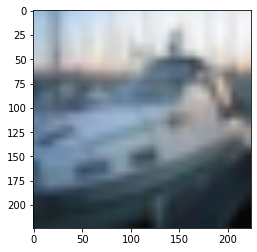

In [32]:
test_image_id=2

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id]

show_img(images[test_image_id])
print(get_CIFAR10_class(pred[test_image_id]))

In [38]:
images[0].numpy().shape

(3, 224, 224)

## Viewing images & normalization - Under the hood

In [39]:
pred

tensor([3, 1, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 1,
        5, 2, 3, 2, 9, 6, 6, 5, 4, 5, 9, 5, 4, 1, 9, 5, 2, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 8, 3, 8, 8, 7, 3, 3, 3, 7, 3, 6, 3])

In [42]:
images.size()

torch.Size([64, 3, 224, 224])

In [44]:
images[0].size()

torch.Size([3, 224, 224])

In [ ]:
plt.imshow()

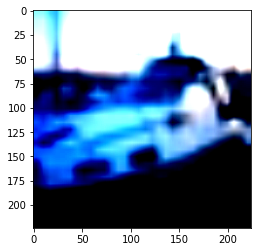

In [48]:
plt.imshow(np.clip(np.transpose(images[test_image_id],(1,2,0)),0,1))

In [ ]:
z = (x-m)/std

In [51]:
def denormalize(tensor):
  tensor = tensor*std + mean
  return tensor

In [54]:
def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)

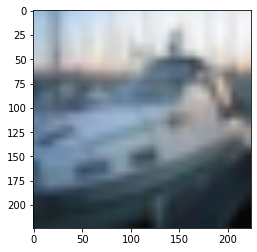

In [55]:
show_img(images[test_image_id])

## Accuracy of the model

In [56]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0

    cnt = 0
    #set_trace()
    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)
        print(output)
        cnt+=1
        
        if cnt > 0:
          break

tensor([[1.0787e-03, 1.3690e-02, 8.0182e-03, 7.9596e-01, 1.4491e-04, 3.4324e-02,
         1.3441e-01, 9.5093e-03, 1.8785e-03, 9.9225e-04],
        [4.8904e-02, 5.6434e-01, 2.7638e-05, 2.5152e-05, 7.2671e-06, 5.8636e-06,
         2.1539e-05, 4.9652e-06, 3.8297e-01, 3.6944e-03],
        [7.7484e-04, 3.3058e-03, 4.0012e-07, 4.6047e-07, 4.4840e-07, 1.6164e-08,
         2.1417e-08, 5.2920e-07, 9.9588e-01, 4.1588e-05],
        [5.3985e-01, 2.1046e-03, 1.9356e-01, 6.2174e-02, 8.5054e-04, 8.8313e-04,
         2.1353e-03, 2.1995e-03, 1.9408e-01, 2.1611e-03],
        [8.4428e-08, 1.0254e-06, 4.0029e-03, 1.9224e-04, 7.0415e-05, 1.3584e-05,
         9.9572e-01, 1.1330e-07, 7.1407e-08, 4.4102e-07],
        [5.2007e-06, 1.0104e-05, 7.8435e-05, 2.9784e-02, 2.5976e-03, 5.1040e-02,
         9.1627e-01, 1.9727e-04, 3.3711e-07, 1.7974e-05],
        [9.6630e-06, 9.9195e-01, 2.8658e-07, 2.6926e-05, 4.6521e-08, 2.4538e-05,
         2.1485e-06, 2.4377e-05, 1.3581e-05, 7.9434e-03],
        [3.7353e-02, 1.1219

In [58]:
pred == labels

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True])

In [59]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0

    cnt = 0

    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)

        pred = torch.argmax(output, 1)
        total += labels.size(0)        

        cnt+=1
        
        if cnt > 0:
          break

In [60]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0


    for batch, (images, labels) in enumerate(testloader,1):
        
        logps = model(images)
        output = torch.exp(logps)
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        print(f'Batch ({batch}/{len(testloader)})')
        
        if batch == 5:
          break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/157)
Batch (2/157)
Batch (3/157)
Batch (4/157)
Batch (5/157)
Accuracy of the model on 320 test images: 80.9375% 
